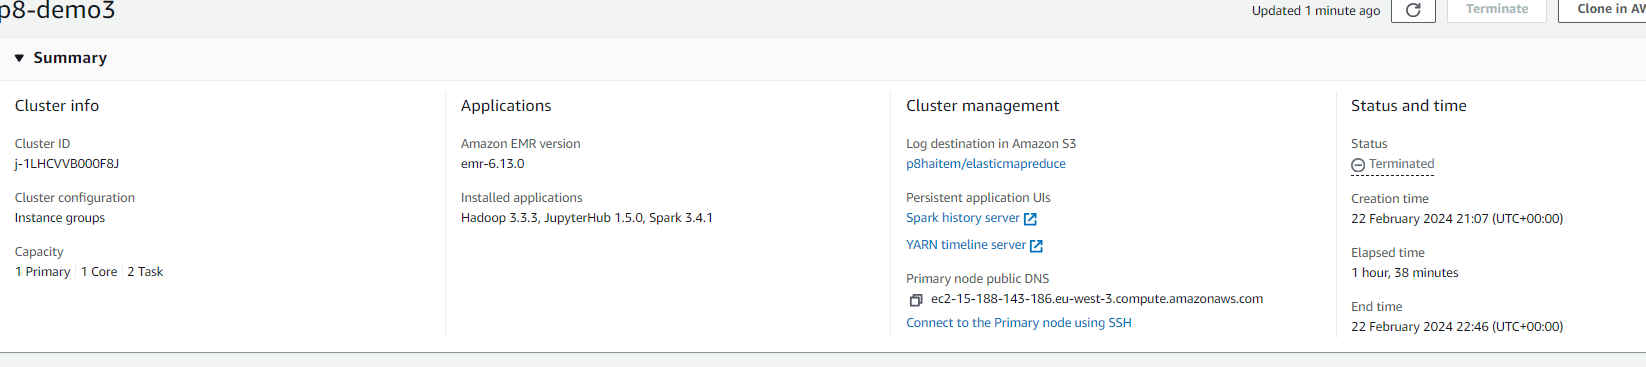

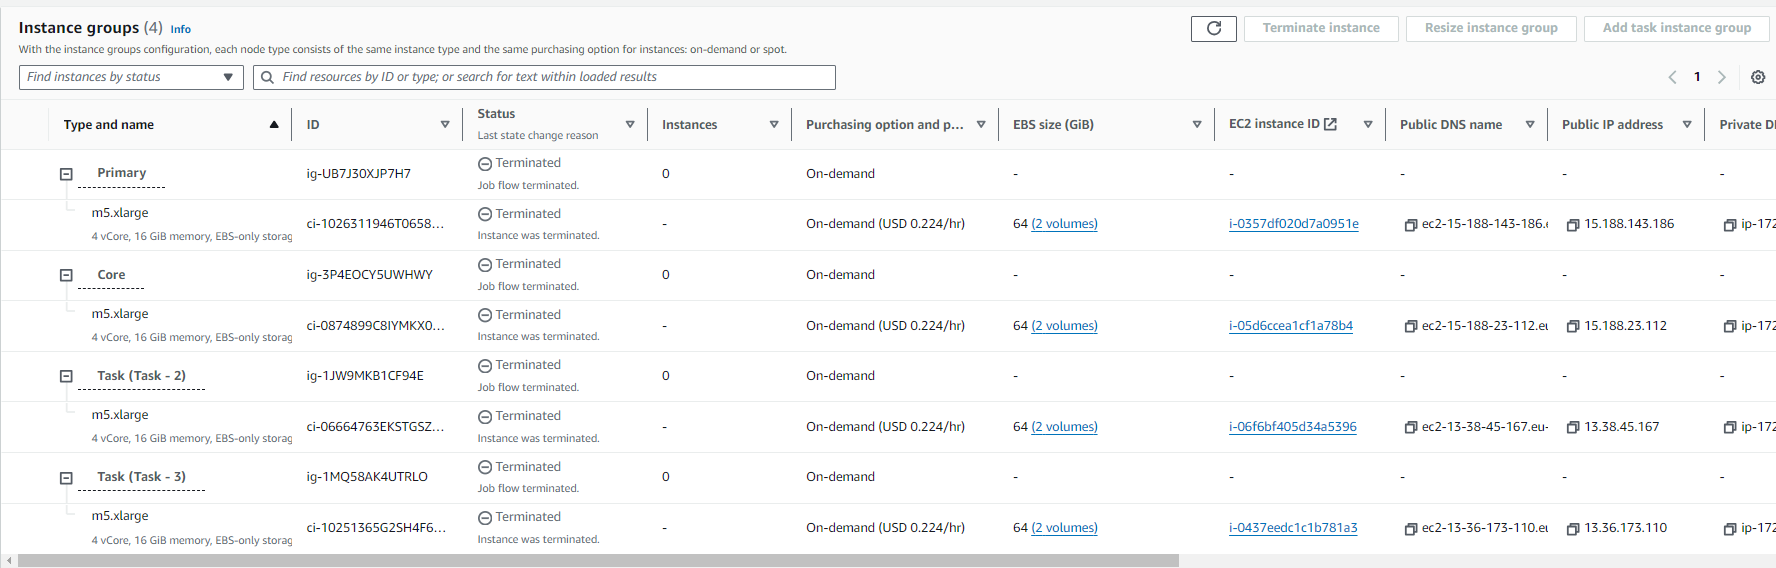

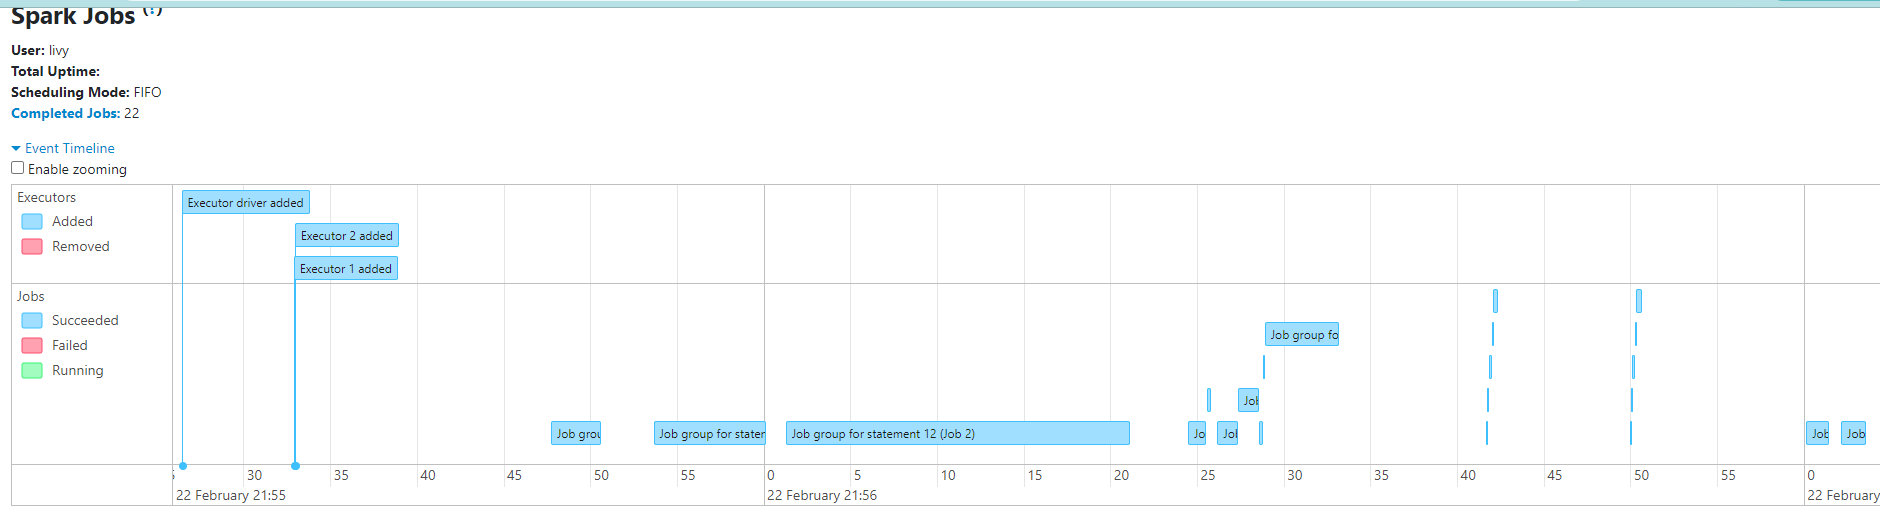

# 1 - IMPORT LIBRAIRIES 

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib
%matplot inline

import matplotlib.pyplot as plt

import io
import os

# TENSORFLOW / KERAS
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# PYSPARK SQL
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split,  udf
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.functions import element_at, split, size, col
from pyspark.sql.types import ArrayType, FloatType, IntegerType

#PYSPARK ML LIB
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
8,application_1708636497282_0008,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

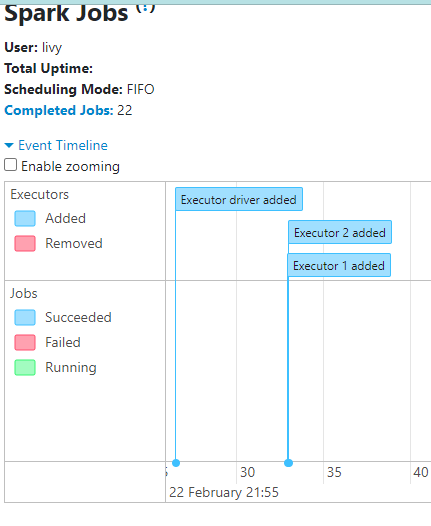

# 2 - Define S3 pathes (Only for EMR Instance, go to Step 1 of Google Colab)

In [2]:
#PATH = 's3://p8haitem'
PATH = 's3://p8haitem/DemoSoutenance'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
PATH_Result_PCA = PATH+'/Results_PCA'

print('PATH:            ' + PATH +\
      '\nPATH_Data:       ' + PATH_Data +\
      '\nPATH_Result:     ' + PATH_Result +\
      '\nPATH_Result_PCA: ' + PATH_Result_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:            s3://p8haitem/DemoSoutenance
PATH_Data:       s3://p8haitem/DemoSoutenance/Test
PATH_Result:     s3://p8haitem/DemoSoutenance/Results
PATH_Result_PCA: s3://p8haitem/DemoSoutenance/Results_PCA

# 3 - Define spark

In [3]:
spark = (SparkSession.builder.appName('P8').master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
        )

#spark = SparkSession.builder.master("local[*]").appName("PCAExample2").config("spark.driver.memory", "32g").getOrCreate()
#spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 4 - Load images

In [4]:
# Read images in binary file format using Spark /
# Lire les images au format de fichier binaire en utilisant Spark
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------+----------+
|path                                                    |label     |
+--------------------------------------------------------+----------+
|s3://p8haitem/DemoSoutenance/Test/Watermelon/134_100.jpg|Watermelon|
|s3://p8haitem/DemoSoutenance/Test/Watermelon/144_100.jpg|Watermelon|
|s3://p8haitem/DemoSoutenance/Test/Watermelon/142_100.jpg|Watermelon|
|s3://p8haitem/DemoSoutenance/Test/Watermelon/146_100.jpg|Watermelon|
|s3://p8haitem/DemoSoutenance/Test/Watermelon/138_100.jpg|Watermelon|
+--------------------------------------------------------+----------+
only showing top 5 rows

None

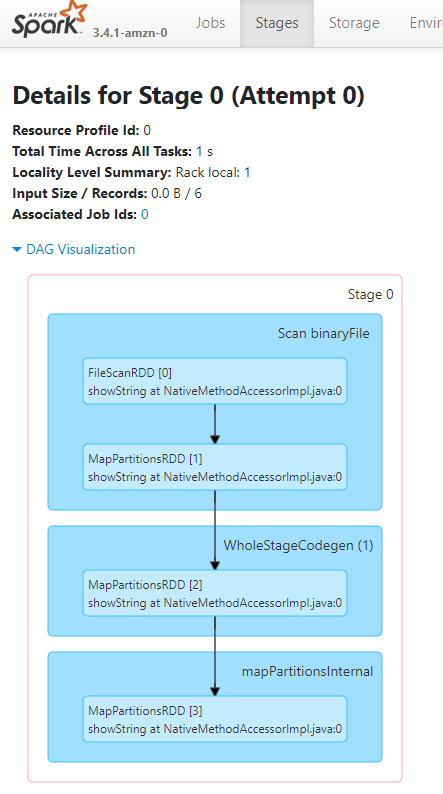

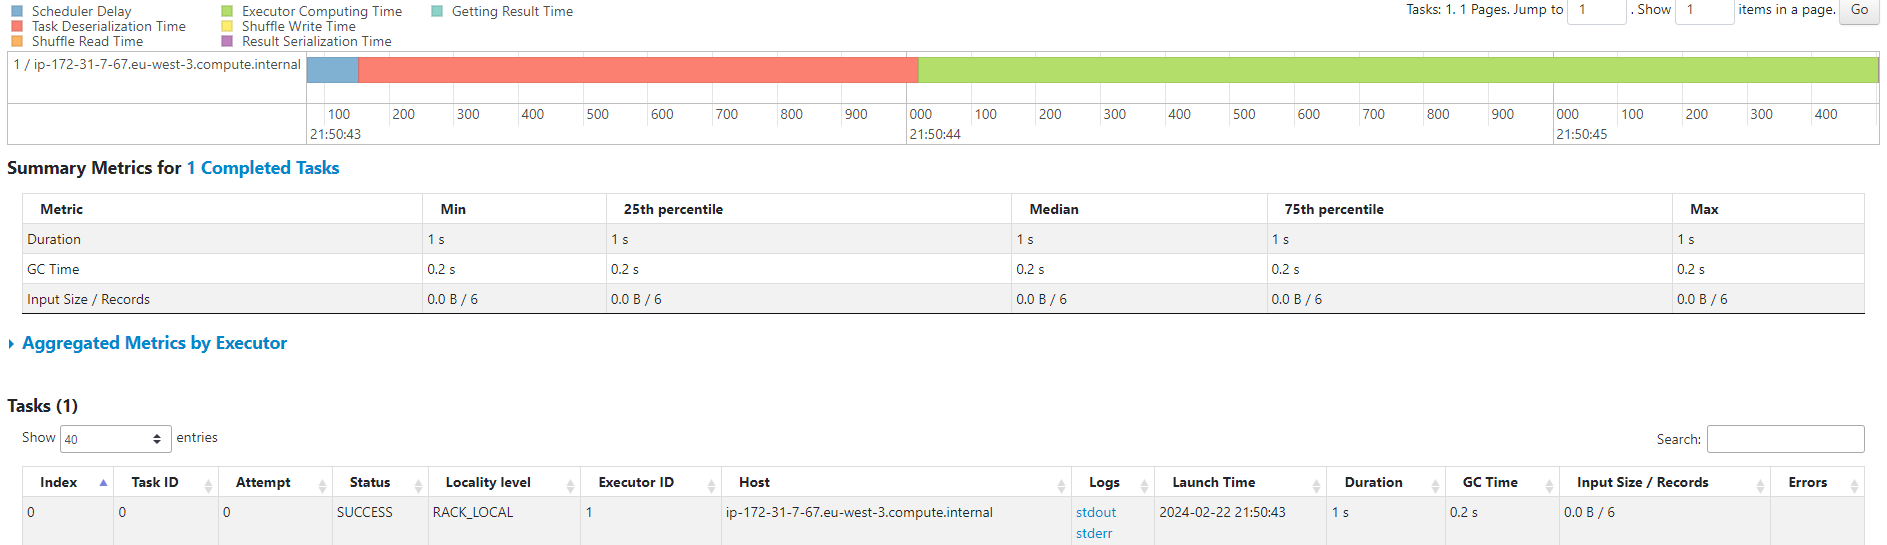

# 5 - Define SparkContext

In [6]:
sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 6 Transfer learning: MobileNetV2

 Transfer learning using the **MobileNetV2** model to extract image features. MobileNetV2 is chosen for its speed compared to other models. The model architecture aims to retrieve a feature vector of dimensions (1,1,1280) for subsequent fruit classification. Initially, the images are of size (100,100,3) but are resized to (224,224,3) to match the model's requirements. The process involves loading MobileNetV2 with precomputed weights from ImageNet, followed by creating a new model with MobileNetV2's input and output from its second-to-last layer.

In [7]:
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# 7 - Weights broadcasting

broadcasting the weights of a TensorFlow model (new_model) across clusters using Apache Spark's broadcast mechanism (sc.broadcast).

In [8]:
broadcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 8 - Modelisation
Returns a MobileNetV2 model with top layer removed
and broadcasted pretrained weights.

In [9]:
def model_fn():
    # Load MobileNetV2 with ImageNet weights and freeze layers / Charger MobileNetV2 avec les poids d'ImageNet et geler les couches
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))

    # Freeze all layers to prevent training / Geler toutes les couches pour éviter l'apprentissage
    for layer in model.layers:
        layer.trainable = False

    # Create a new model using the input of MobileNetV2 and output of its second-to-last layer /
    # Créer un nouveau modèle en utilisant l'entrée de MobileNetV2 et la sortie de sa couche avant la dernière
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)

    # Set the weights of the new model to the broadcasted weights /
    # Définir les poids du nouveau modèle comme les poids diffusés
    new_model.set_weights(broadcast_weights.value)

    return new_model


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1708636497282_0008/container_1708636497282_0008_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:403: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [11]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Write results on parquet form

In [12]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

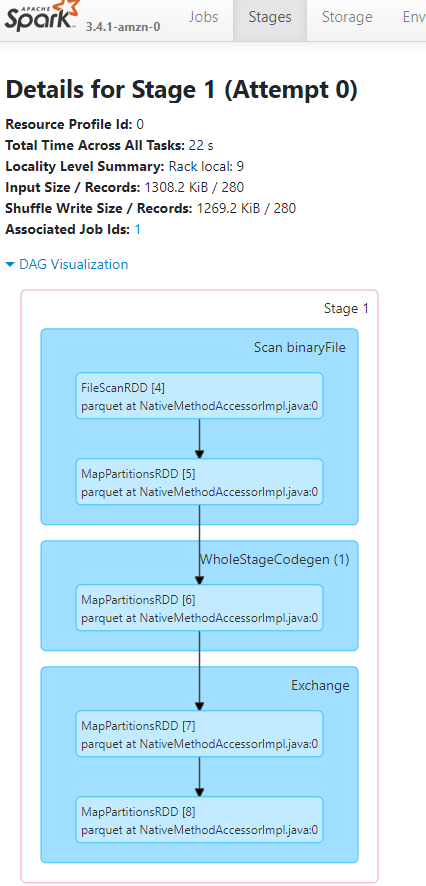

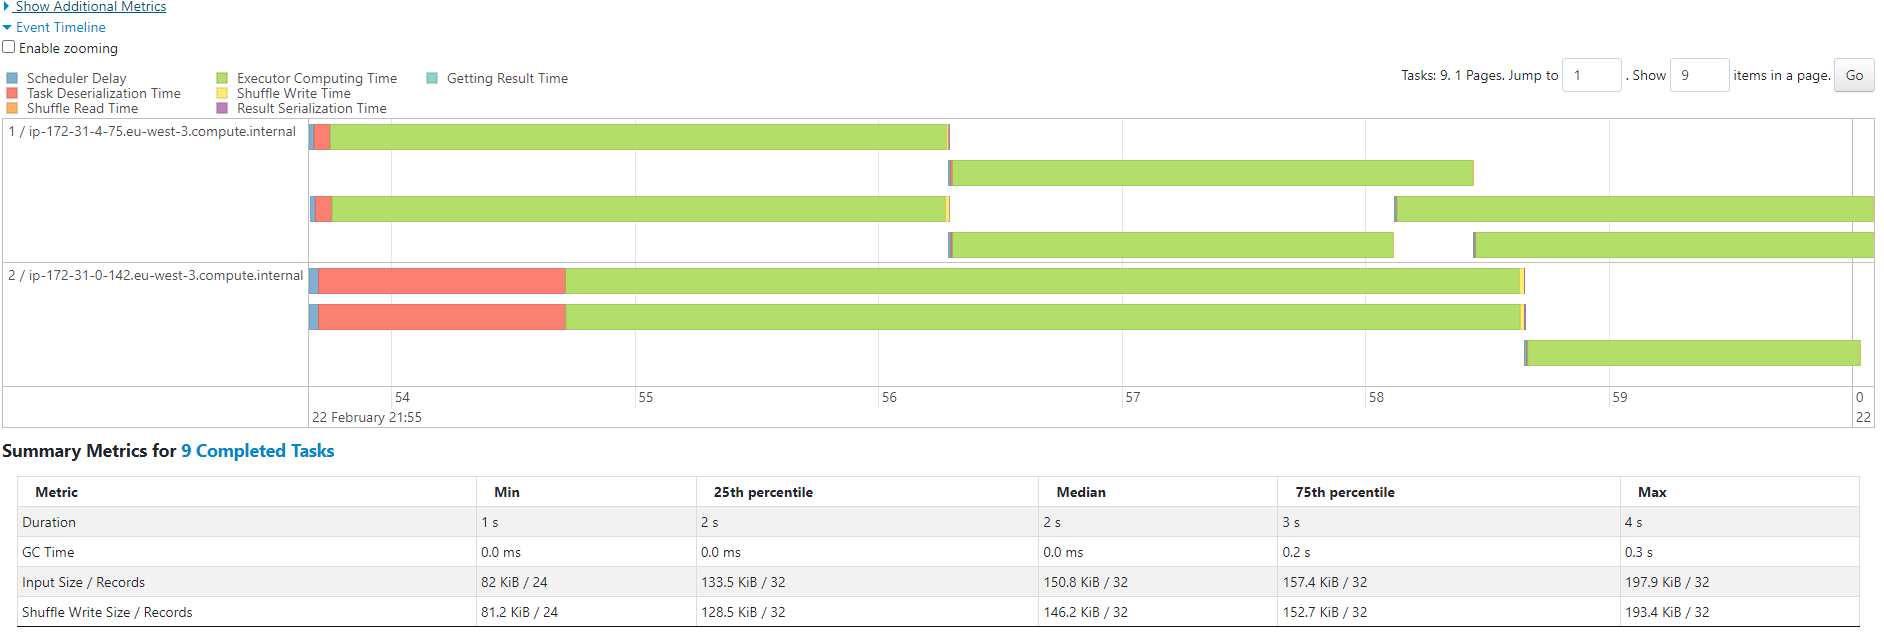

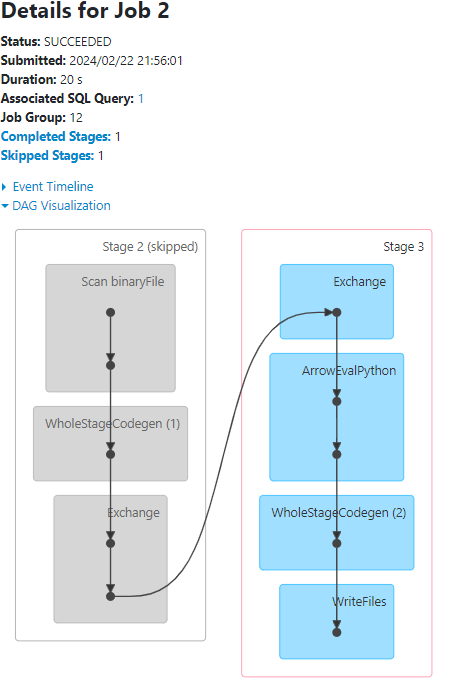

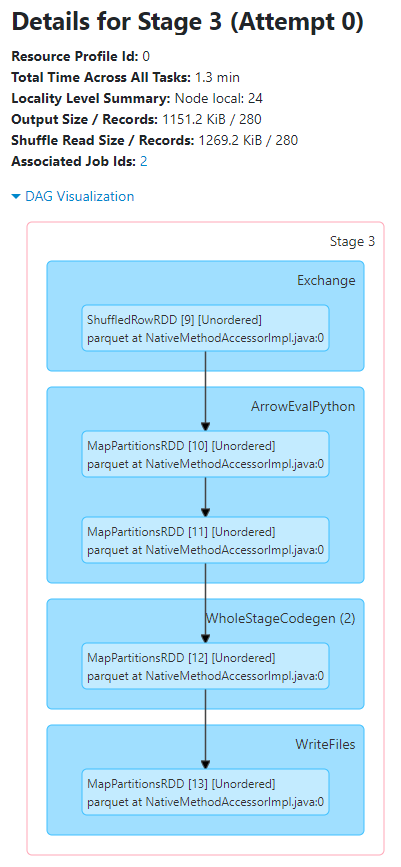

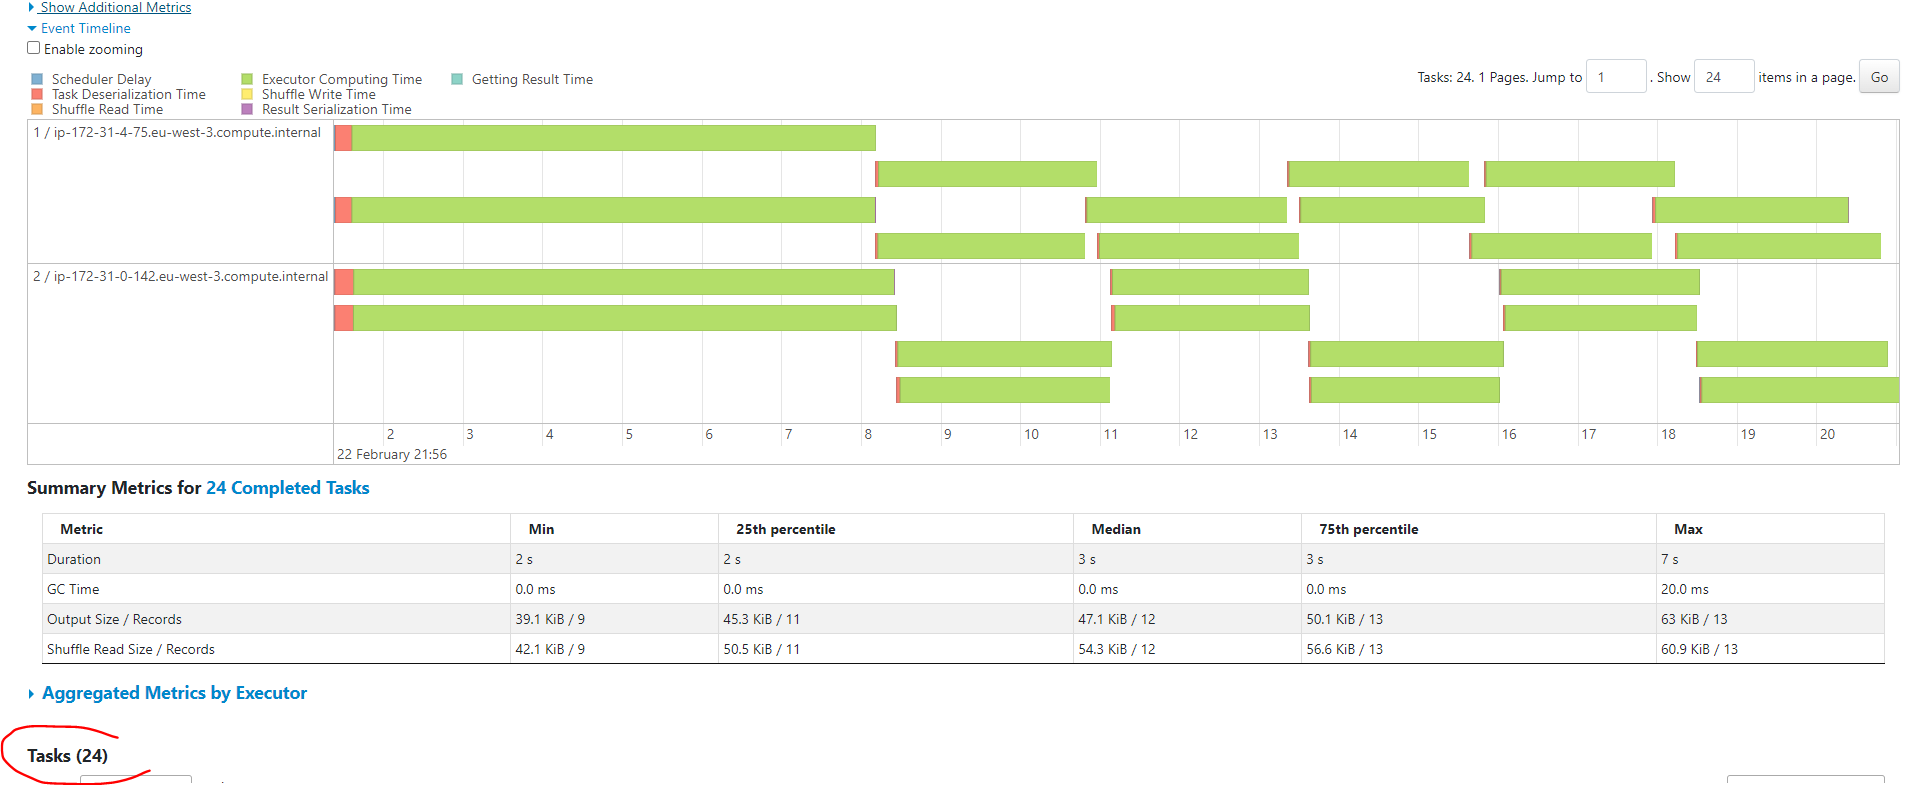

# 9 Load registred data and validate the results

In [13]:
#PATH = 's3://p8haitem'
#PATH_Data = PATH+'/Test'
#PATH_Result = PATH+'/Results'
#PATH_Result_PCA = PATH+'/Results_PCA'
#
#print('PATH:            ' + PATH +\
#      '\nPATH_Data:       ' + PATH_Data +\
#      '\nPATH_Result:     ' + PATH_Result +\
#      '\nPATH_Result_PCA: ' + PATH_Result_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# PCA

In [15]:
# Define a UDF to convert the features column to a DenseVector
def array_to_vector(arr):
    return Vectors.dense(arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df['features_vector'] = df.apply(lambda x: array_to_vector(x['features']), axis=1)
df = df.drop(['features'], axis=1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Convert Pandas DataFrame to PySpark DataFrame
df_pyspark = spark.createDataFrame(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Initialize StandardScaler
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withStd=True, withMean=True)
# Create a pipeline to apply the scaler to the features_vector column only
#pipeline = Pipeline(stages=[scaler])

# Fit and transform the data using the pipeline
scaler_model = scaler.fit(df_pyspark)
df_result = scaler_model.transform(df_pyspark)

# Initialize PCA. 1280 is the maximum possible components as the vector size is 1280
pca = PCA(k=1280, inputCol="scaled_features", outputCol="pca_features")
# Fit the model to the data
pca_model = pca.fit(df_result)
# Get the explained variance for each principal component
explained_variance = pca_model.explainedVariance
# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Transform the data using the PCA model
df_result = pca_model.transform(df_result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

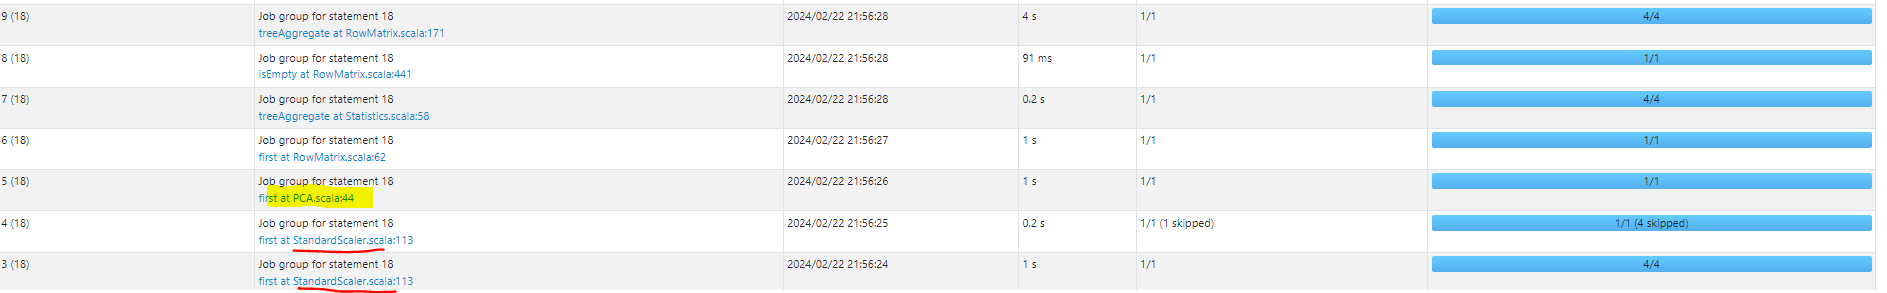

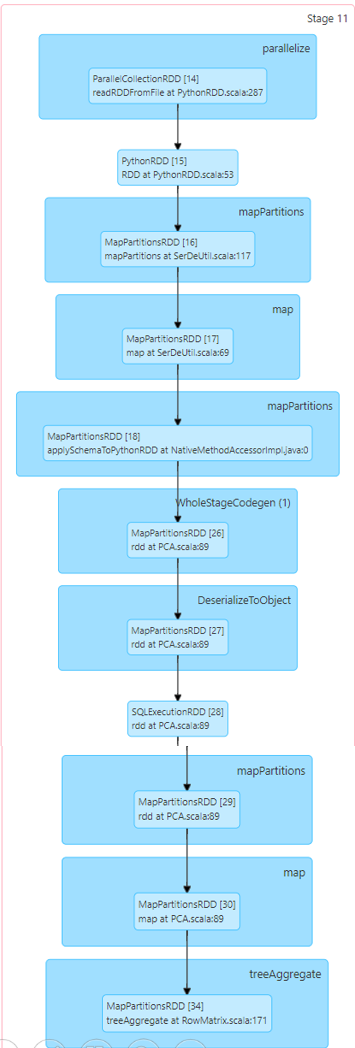

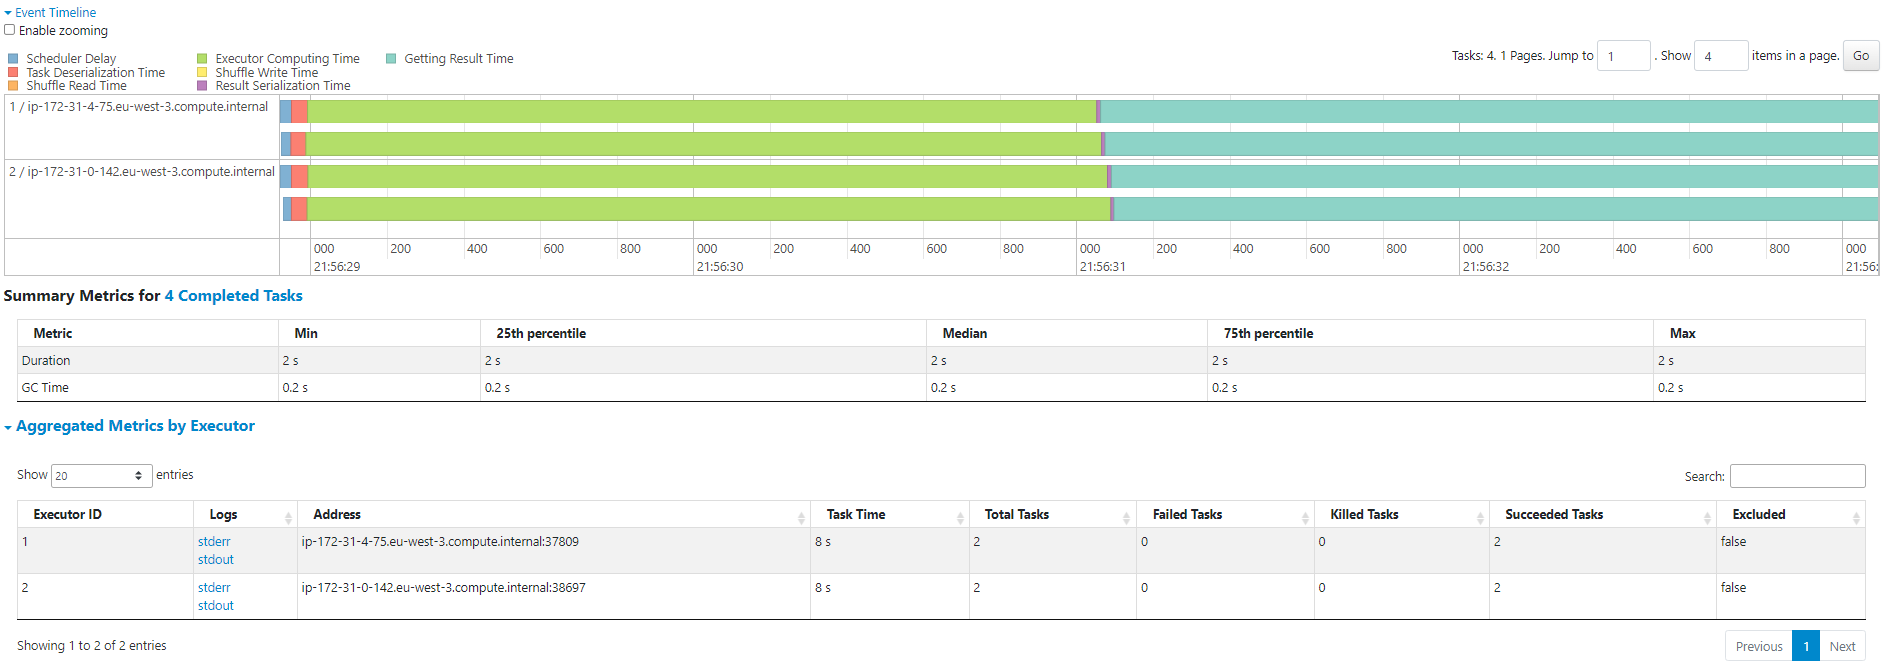

In [19]:
def ncomponents_with_target_explained_ratio(df_result, cumulative_variance, target_ratio=0.99):
    # Determine the number of components to achieve the target ratio
    n_components = int(np.argmax(cumulative_variance >= target_ratio))
    # Add a new column indicating the size of the pca_features array
    pca_features_col = f"pca_features_{int(target_ratio * 100)}"

    # Initialize PCA having n_components
    pca = PCA(k=n_components, inputCol="scaled_features", outputCol=pca_features_col)
    # Fit the model to the data
    pca_model = pca.fit(df_result)
    # Transform the data using the PCA model
    df_result = pca_model.transform(df_result)

    return n_components, df_result

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

for idx, ratio in enumerate([0.80, 0.90]):
    num_components, df_result = ncomponents_with_target_explained_ratio(df_result, cumulative_variance, target_ratio=ratio)

    # Determine which subplot to use
    ax = ax1 if idx == 0 else ax2

    # Plot the variance explained by each principal component
    ax.bar(range(1, num_components + 1), explained_variance[:num_components], label='Variance per PC')
    ax.plot(range(1, num_components + 1), cumulative_variance[:num_components], marker='o',
            linestyle='-', color='r', label='Cumulative Variance')
    ax.axvline(x=num_components + 1, color='k', linestyle='--', label=f'{int(ratio * 100)}% Cumulative Variance')

    # Add annotation for the number of components at ratio% cumulative variance
    ax.annotate(f'{num_components} components at {int(ratio * 100)}%',
                xy=(num_components, cumulative_variance[num_components - 1]),
                xytext=(num_components + 5, cumulative_variance[num_components - 1] - 0.1))
    
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_title(f'Explained Variance of Principal Components {int(ratio * 100)}')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance / Cumulative Variance')
    ax.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

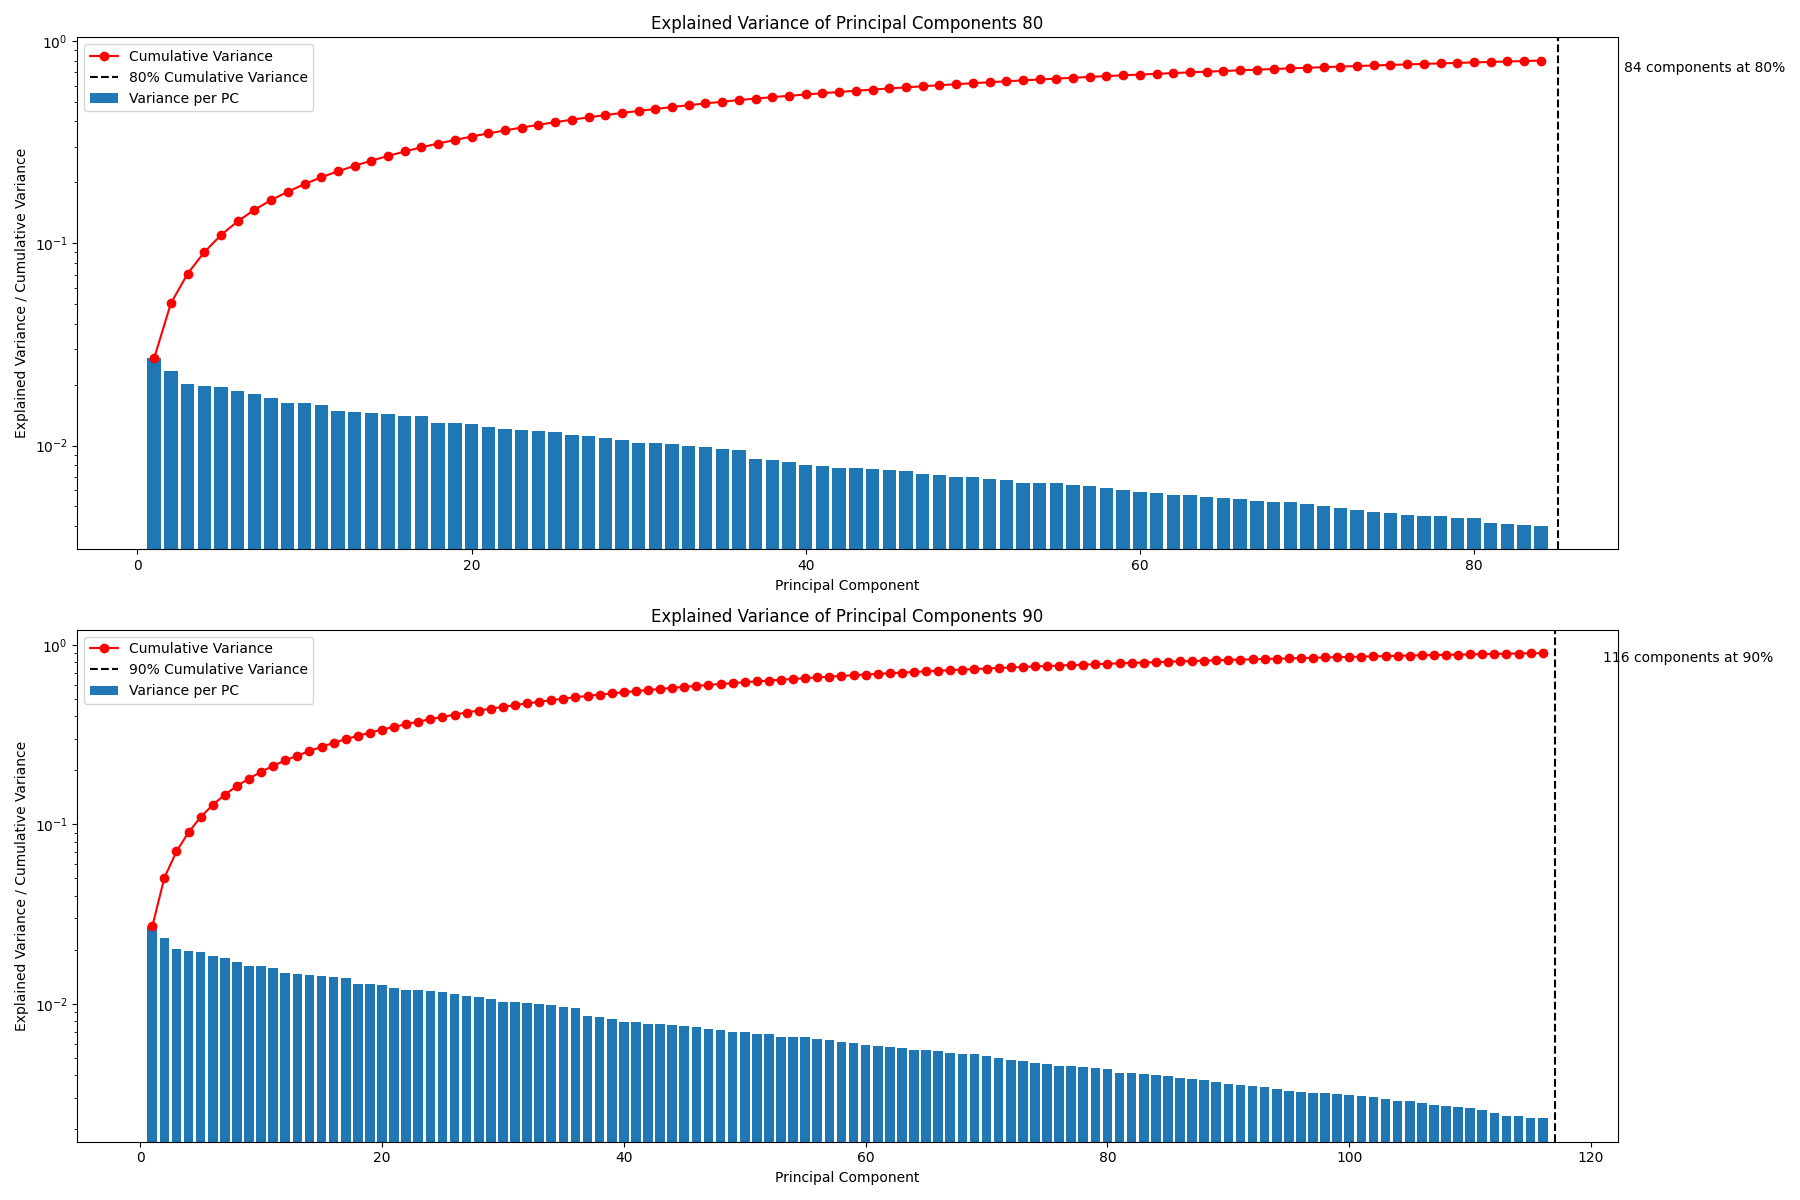

In [21]:
%matplot plt

# 10 - Export results into CSV and PARQUET

In [22]:
from pyspark.sql.functions import col

# Save DataFrame to Parquet format
df_result.write.mode("overwrite").parquet(PATH_Result_PCA)

# Save DataFrame to CSV format
for column in df_result.columns:
    df_result = df_result.withColumn(column, col(column).cast("string"))

df_result.write.mode("overwrite").csv(PATH_Result_PCA)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

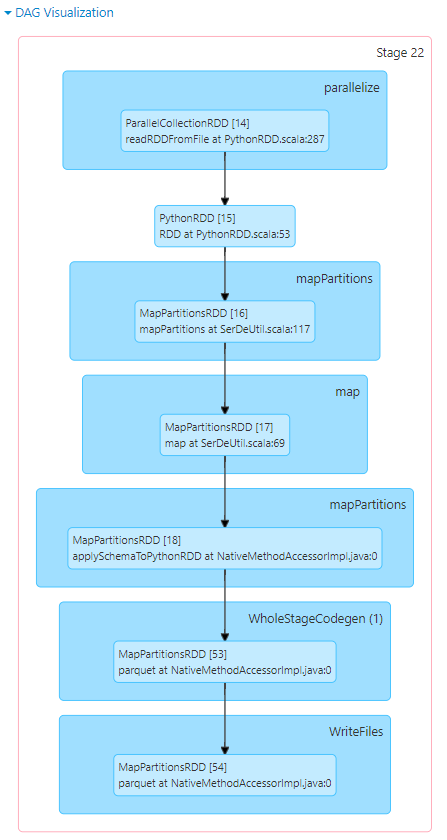

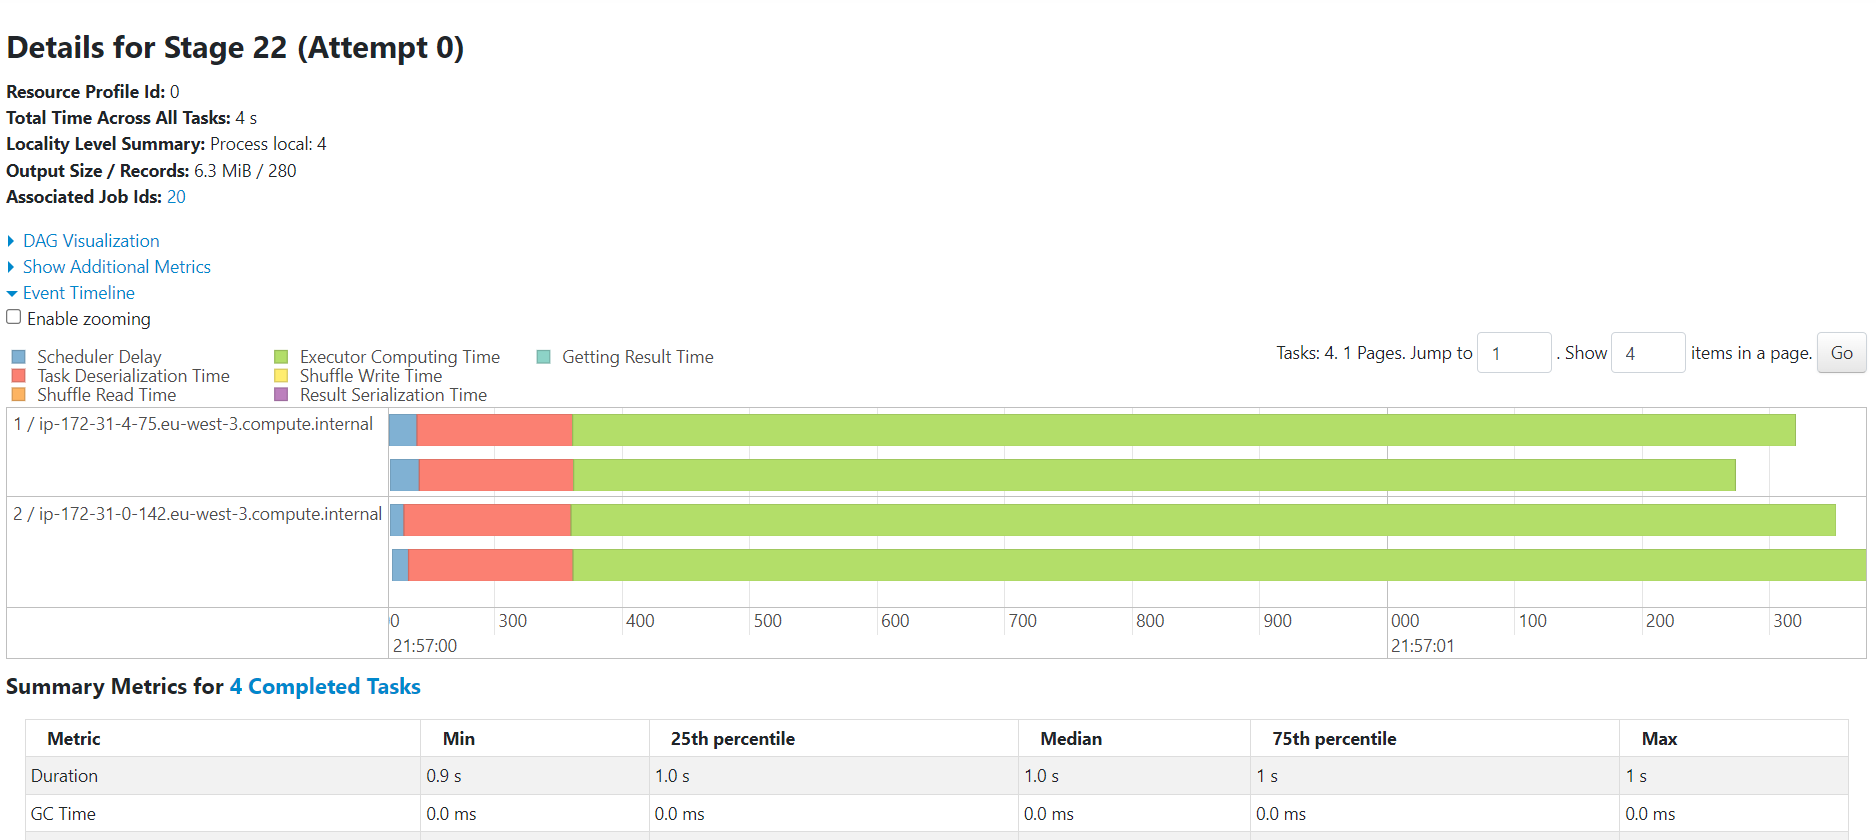

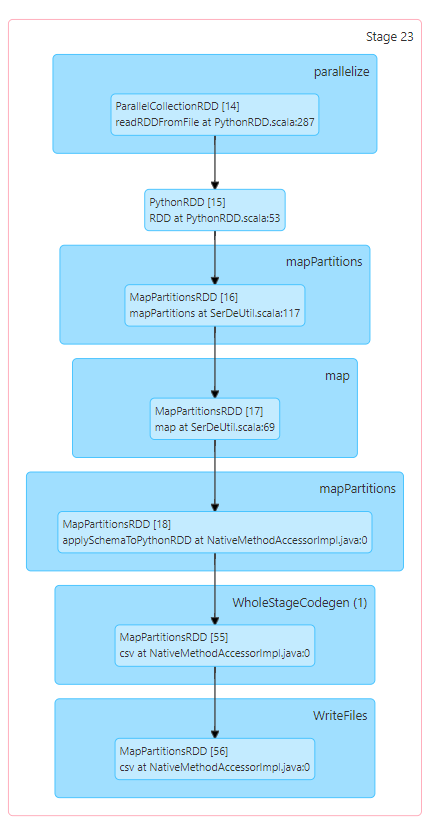

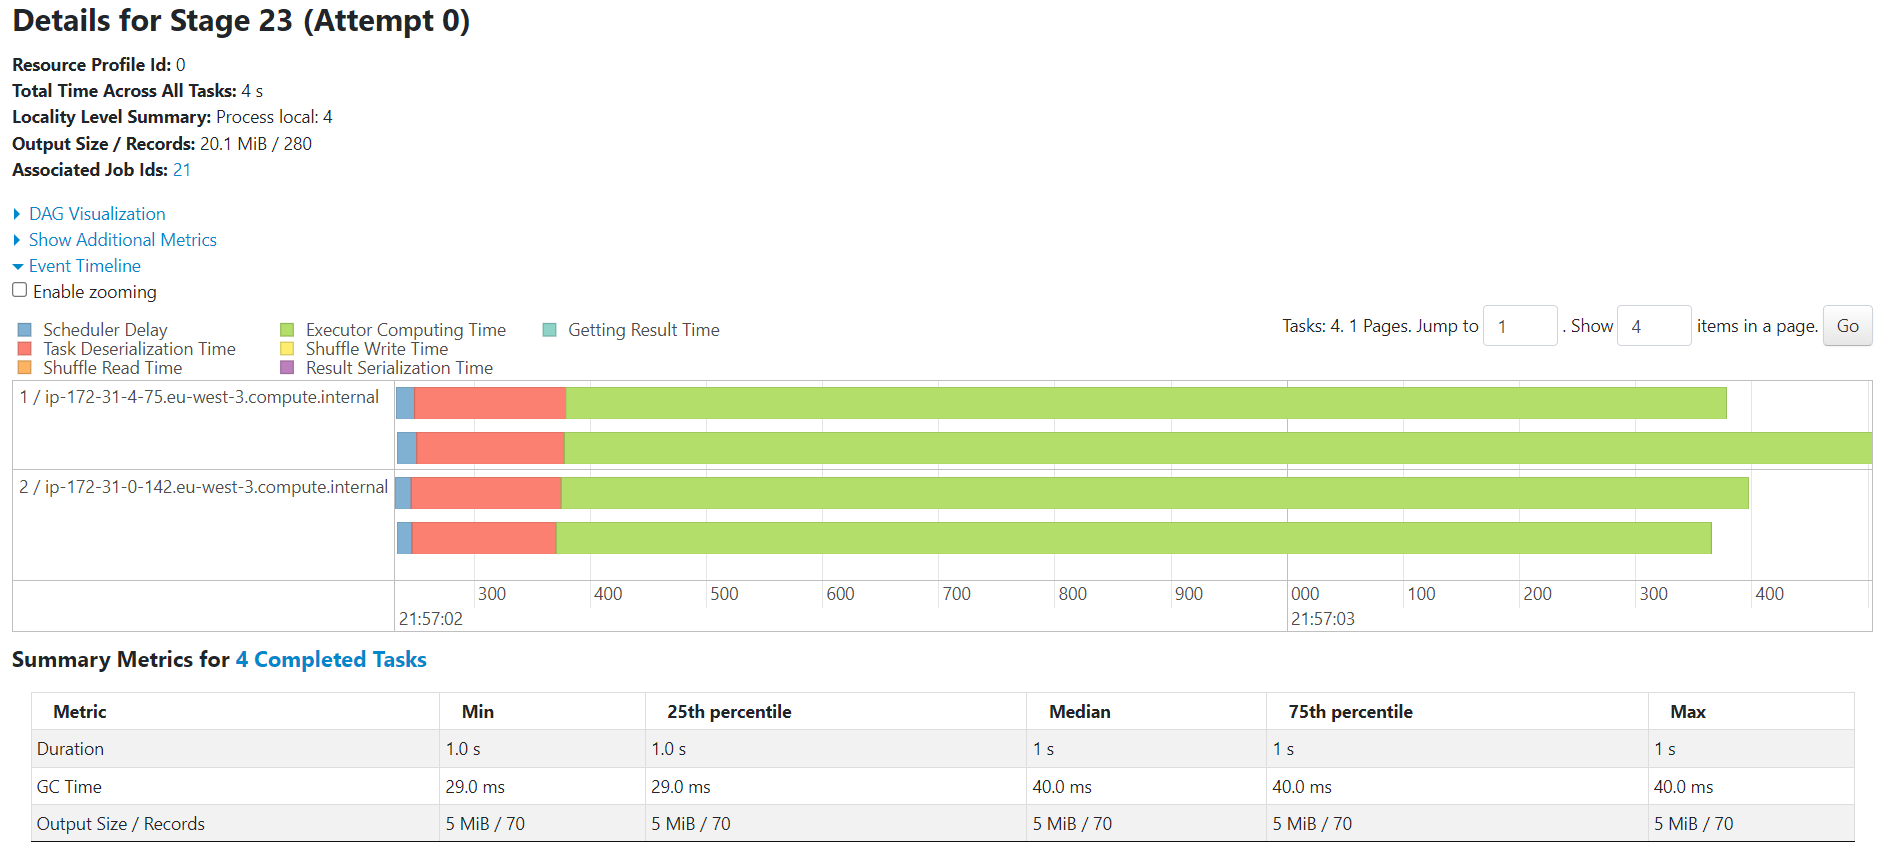